In [1]:
import numpy as np
import torch
import cv2
from ultralytics.engine.results import Masks

In [2]:
from PIL import ImageFont, ImageDraw, Image

In [3]:
import matplotlib.pyplot as plt

In [4]:
colors = """
#B52CFF
#348F00
#6B2CFF
#FFFF2C
#FF3535
#FF7A00
#0DA3FF
#FFD700
#20C9A5
#E91E63
#D4AC2B
#8CFF00
#FF007A
#2E91E5
#AFFF3C
#C71585
#FF6F00
#009688
#FFCC00
#4A90E2
#00BCD4
#CDDC39
#FF4081
#795548
#FFC400"""

In [5]:
colors = [np.array([int(c[i:i+2], 16) for i in (1, 3, 5)]) for c in colors.split("\n") if c]

In [6]:
import json

with open("coco_classes_eng.json") as f:
    eng_labels = json.load(f)

with open("coco_classes_ukr.json") as f:
    ukr_labels = json.load(f)

In [7]:
img_path = "img/girl.jpg"

In [8]:
image = cv2.imread(img_path)


# Get the dimensions of the image
height, width, _ = image.shape

# FOR DEMONSTRATION PURPOSES, I AM RESIZING THE IMAGE
# IT's WAY TOO FUCKING BIG
height, width = height // 3, width // 3
image = cv2.resize(image, (width, height))


# Set the figure size based on the image dimensions
plt.figure(figsize=(width / 100, height / 100))

<Figure size 1008x1344 with 0 Axes>

<Figure size 1008x1344 with 0 Axes>

In [9]:
from ultralytics import YOLO

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")

# Display model information (optional)
model.info()

YOLOv9c-seg summary: 654 layers, 27,897,120 parameters, 0 gradients


(654, 27897120, 0, 0.0)

In [10]:
location = "ukr"

In [11]:
results = model(image)


0: 640x480 3 persons, 1 backpack, 2 umbrellas, 1 handbag, 1 potted plant, 1 cell phone, 9748.5ms
Speed: 130.6ms preprocess, 9748.5ms inference, 119.5ms postprocess per image at shape (1, 3, 640, 480)


In [12]:
fontpath = "./fonts/ttNormPro.ttc"
font = ImageFont.truetype(fontpath, 14)

In [13]:
def overlay_masks_on_image(image, results, alpha=0.2, labels=True):
    """
    Overlay masks for multiple instances per class on the original image.

    Args:
        image: Original image (as a NumPy array).
        masks: Dictionary where each key is a class ID, and the value is a list of binary masks (one for each instance).
        alpha: Transparency of the overlay (0 = transparent, 1 = opaque).
    """
    objects = {}
    counters = {}
    
    for c, mask_obj, box_obj in zip(results[0].boxes.cls.type(torch.int).numpy(), results[0].masks.xy, results[0].boxes.xyxy):

        # Convert the polygon coordinates to integer
        polygon = np.array(mask_obj, dtype=np.int32)

        # Create a mask for the polygon
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 1)

        class_name = ukr_labels[str(c)] if location == "ukr" else eng_labels[str(c)]
        
        num = counters.get(class_name, 0)
        if num == 0:
            counters[class_name] = 1
            obj_text = class_name
        else:
            counters[class_name] += 1
            obj_text = f"{class_name} {num}"
        objects[obj_text] = {}
        objects[obj_text]["mask"] = mask
        objects[obj_text]["bbox"] = box_obj


        # Get the color for the current class
        color = colors[c % len(colors)]

        # Create a color mask (with the same shape as the image)
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color

        # Overlay the mask on the image using the transparency factor
        image = cv2.addWeighted(image, 1, color_mask, alpha, 0)

        # Draw the polygon outline on the image
        image = cv2.polylines(image, [polygon], isClosed=True, color=color.tolist(), thickness=2, lineType=cv2.LINE_AA)

        if labels == True:
            # Find the centroid of the mask to place the label
            moments = cv2.moments(mask)
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
                position = (cX, cY)
                        
                # Put the text on the image                
                img_pil = Image.fromarray(image)
                draw = ImageDraw.Draw(img_pil)

                bbox = draw.textbbox(position, obj_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                centered_position = (position[0] - text_width // 2, position[1] - text_height // 2)

                x1, y1, x2, y2 = draw.textbbox(centered_position, obj_text, font=font)
                # draw.rectangle((x1-5, y1-5, x2+5, y2+5), fill=(250,	246, 245))
                draw.rounded_rectangle((x1-5, y1-5, x2+5, y2+5), fill=(250,	246, 245), radius=8)
                        
                draw.text(centered_position, obj_text, font=font, fill=(0, 0, 0, 255))
                image = np.array(img_pil)

    return image, objects # BINARY masks and bounding boxes

In [14]:
# Overlay masks on the image
output_image, objects = overlay_masks_on_image(image, results)

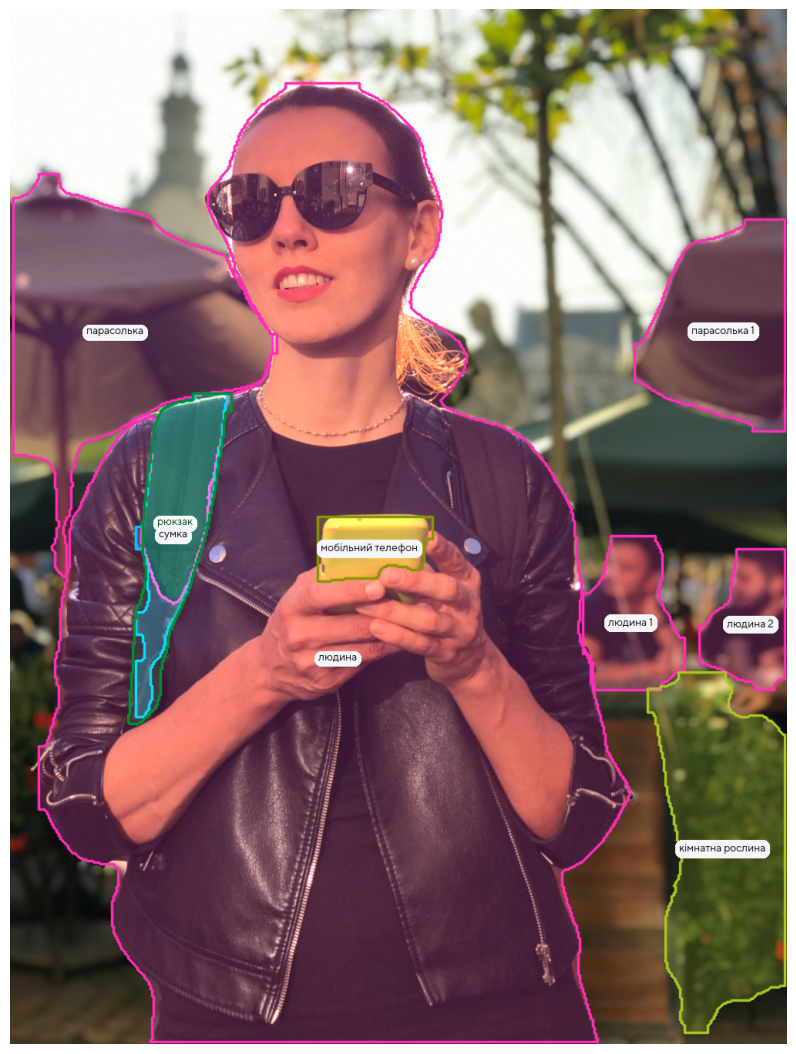

In [15]:
plt.figure(figsize=(width / 100, height / 100))
# Display the image
plt.imshow(output_image[..., ::-1])
plt.axis('off')  # Hide the axis
plt.show()

# Remove the background
Select main object and remove everything behind it

In [16]:
def get_main_object_index(objects):
    # Assuming each object has a 'class' label, 'mask', and 'bbox' (bounding box)
        return max(objects, key=lambda i: np.sum(objects[i]['mask']))  # Largest mask area

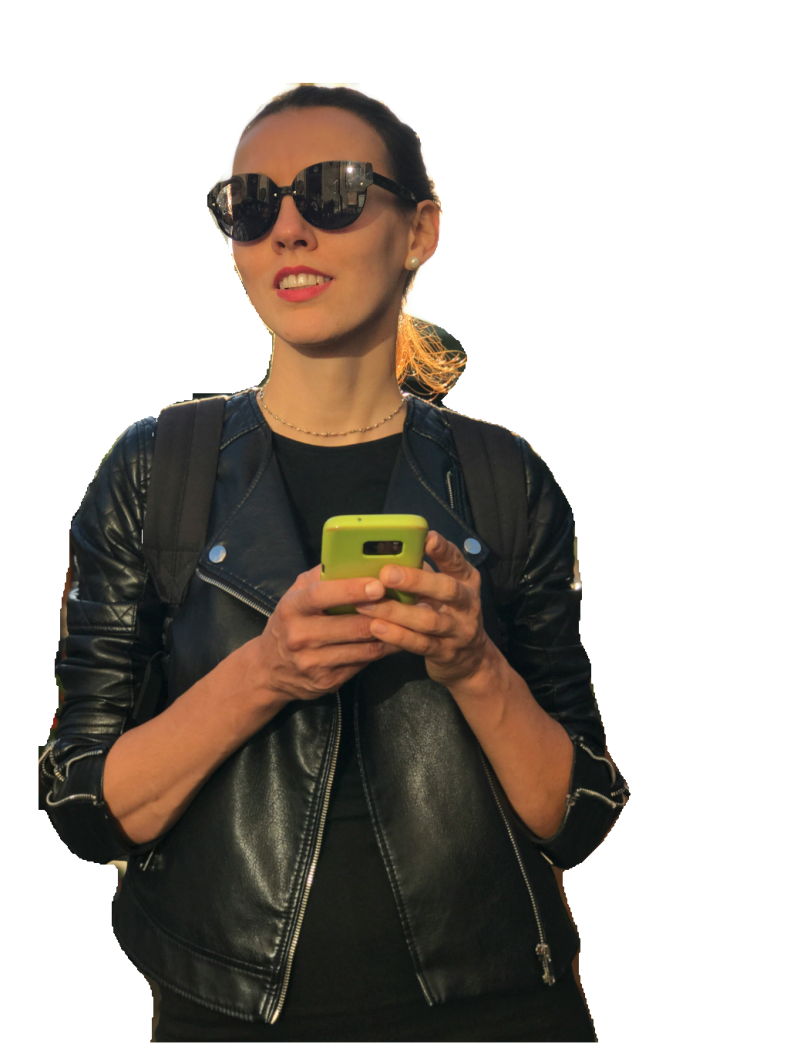

In [17]:
def is_within_proximity(bbox1, bbox2, threshold=20):
    # Calculate if two bounding boxes are within a given pixel proximity threshold
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    return (
        abs(x1 - x2) <= threshold or abs(y1 - y2) <= threshold or
        abs((x1 + w1) - (x2 + w2)) <= threshold or abs((y1 + h1) - (y2 + h2)) <= threshold
    )

def combine_masks(objects, main_object_idx, proximity_threshold=20):
    main_object = objects[main_object_idx]
    combined_mask = main_object['mask'].copy()
    
    for i, obj in enumerate(objects.values()):
        if i != main_object_idx:
            # Check if object is close enough or overlaps with the main object's bounding box
            if is_within_proximity(main_object['bbox'], obj['bbox'], threshold=proximity_threshold):
                combined_mask = cv2.bitwise_or(combined_mask, obj['mask'])  # Add to main mask
    
    return combined_mask

# Identify the main object and combine masks
main_object_idx = get_main_object_index(objects)
if main_object_idx is not None:
    combined_mask = combine_masks(objects, main_object_idx, proximity_threshold=20)

    # Create a copy of the original image
    background_removed_image = image.copy()

    # Convert the image to RGBA (if it's not already in that format)
    background_removed_image = cv2.cvtColor(background_removed_image, cv2.COLOR_BGR2RGBA)

    # Set the background pixels to transparent
    background_removed_image[combined_mask == 0, 3] = 0

    # Display the image with the background removed
    plt.figure(figsize=(width / 100, height / 100))
    plt.imshow(background_removed_image)
    plt.axis('off')  # Hide the axis
    plt.show()

else:
    print("Main object not found.")


# Cut out an object


In [31]:
# !git clone https://github.com/andreas128/RePaint.git
!git clone https://github.com/fenglinglwb/MAT.git 

Cloning into 'MAT'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 199 (delta 42), reused 39 (delta 39), pack-reused 148 (from 1)
Receiving objects: 100% (199/199), 18.89 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Updating files: 100% (67/67), done.


In [32]:
!pip install -r ./MAT/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 4.4 MB/s eta 0:00:0000:0100:01


# Pick up an object

In [18]:
# selected = [masks[i] for i in ["person", "cell phone", "backpack"]]
selected = [objects[i] for i in ["мобільний телефон"]]

In [19]:
# Merge the selected masks into one
merged_mask = np.zeros_like(selected[0]["mask"], dtype=np.uint8)
for obj in selected:
    merged_mask = cv2.bitwise_or(merged_mask, obj["mask"])

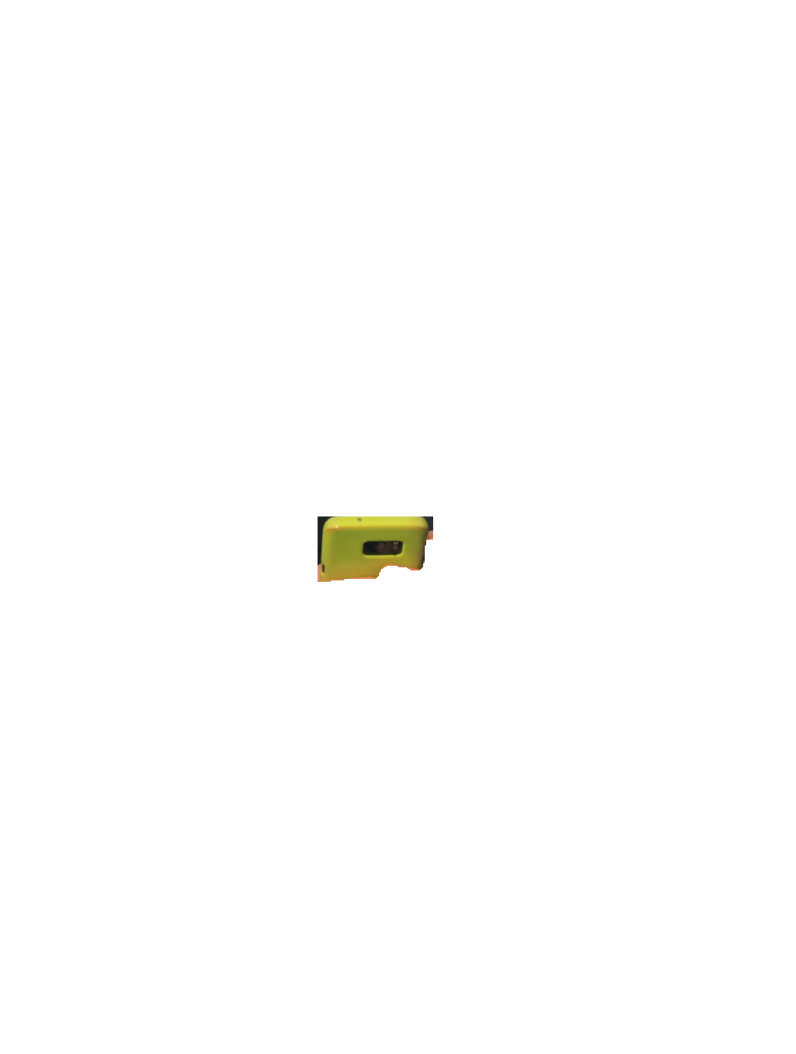

In [20]:
# Create a copy of the original image
pick_up_image = image.copy()

# Convert the image to RGBA (if it's not already in that format)
pick_up_image = cv2.cvtColor(pick_up_image, cv2.COLOR_BGR2RGBA)

# Set the background pixels to transparent
pick_up_image[merged_mask == 0, 3] = 0

# Display the image with the background removed
plt.figure(figsize=(width / 100, height / 100))
plt.imshow(pick_up_image)
plt.axis('off')  # Hide the axis
plt.show()


# Edit the background

In [23]:
# selected = [masks[i] for i in ["person", "cell phone", "backpack"]]
selected = [objects[i] for i in ["людина", "мобільний телефон", "рюкзак"]]

In [26]:
# Merge the selected masks into one
merged_mask = np.zeros_like(selected[0], dtype=np.uint8)
for obj in selected:
    merged_mask = cv2.bitwise_or(merged_mask, obj["mask"])

In [27]:
background_image = cv2.imread("backgrounds/beach.jpg")

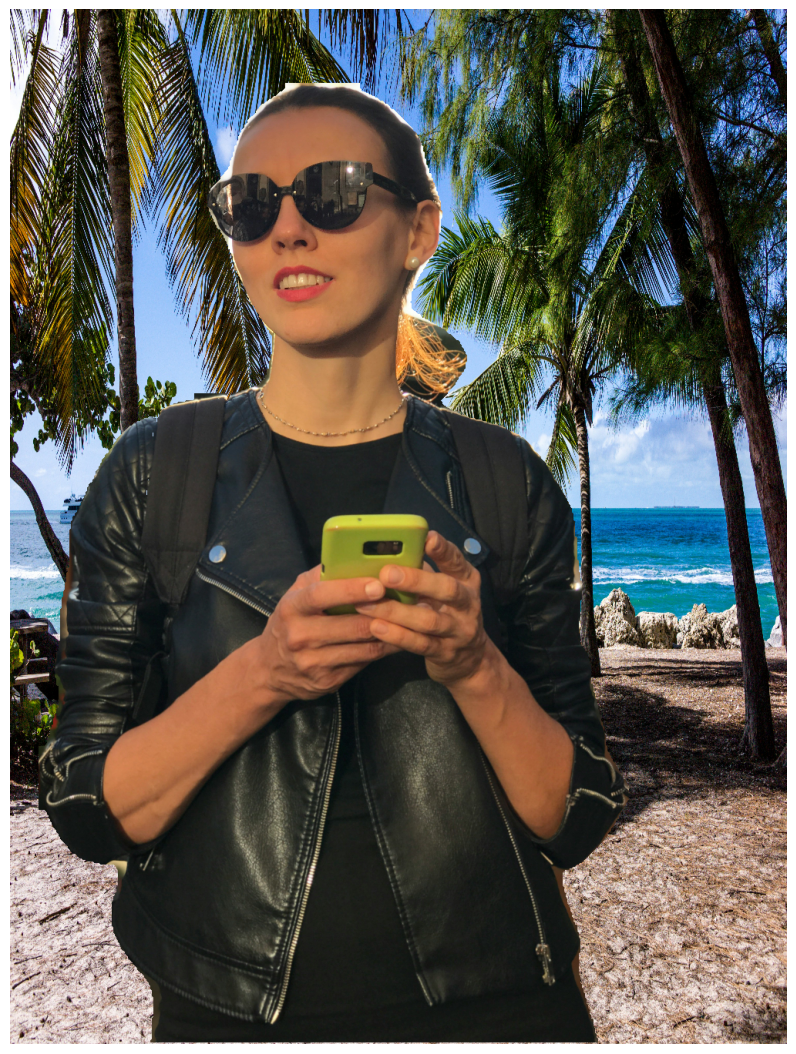

In [28]:
# Resize the background image to match the dimensions of the image
resized_background = cv2.resize(background_image, (image.shape[1], image.shape[0]))

# Overlay the image on top of the resized background
combined_image = resized_background.copy()
combined_image[merged_mask == 1] = image[merged_mask == 1, :3]

# Display the combined image
plt.figure(figsize=(width / 100, height / 100))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')  # Hide the axis
plt.show()